In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
import keras
import imutils
import pytesseract

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path='../data/project/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [4]:
label_dict

{'angry': 0, 'smile': 1}

In [5]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

Exception: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-vijyisc5\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [6]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [7]:
data=np.load('data.npy')
target=np.load('target.npy')

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop
from sklearn.model_selection import train_test_split

In [9]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

In [11]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [12]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name="conv2d_1"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))

    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_2"))
    model.add(Dropout(0.25, name="dropout_2"))

    model.add(Conv2D(128, (3, 3), activation='relu', name="conv2d_3"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"))
    model.add(Dropout(0.25, name="dropout_3"))

    model.add(Flatten(name="flatten"))
    model.add(Dense(512, activation='relu', name="dense_1"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2_rate, name="dropout_4"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [13]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [14]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [15]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Epoch 1/10
158/158 [==============================] - 7s 10ms/step - loss: 1.5161 - accuracy: 0.6573
Epoch 2/10
158/158 [==============================] - 1s 9ms/step - loss: 1.0832 - accuracy: 0.6212
Epoch 3/10
158/158 [==============================] - 1s 9ms/step - loss: 0.9181 - accuracy: 0.7193
Epoch 4/10
158/158 [==============================] - 1s 9ms/step - loss: 0.8430 - accuracy: 0.7205
Epoch 5/10
158/158 [==============================] - 1s 9ms/step - loss: 0.7563 - accuracy: 0.7204
Epoch 6/10
158/158 [==============================] - 1s 9ms/step - loss: 0.8368 - accuracy: 0.7102
Epoch 7/10
158/158 [==============================] - 1s 9ms/step - loss: 0.6456 - accuracy: 0.7576
Epoch 8/10
158/158 [==============================] - 1s 9ms/step - loss: 0.5965 - accuracy: 0.7657
Epoch 9/10
158/158 [==============================] - 1s 9ms/step - loss: 0.5635 - accuracy: 0.7826

158/158 [==============================] - 3s 11ms/step - loss: 1.5044 - accuracy: 0.5829
Epoch 2/10
158/158 [==============================] - 2s 11ms/step - loss: 0.5710 - accuracy: 0.7834
Epoch 3/10
158/158 [==============================] - 2s 11ms/step - loss: 0.4868 - accuracy: 0.8140
Epoch 4/10
158/158 [==============================] - 2s 11ms/step - loss: 0.4845 - accuracy: 0.7986
Epoch 5/10
158/158 [==============================] - 2s 11ms/step - loss: 0.4968 - accuracy: 0.8109
Epoch 6/10
158/158 [==============================] - 2s 11ms/step - loss: 0.3501 - accuracy: 0.8807
Epoch 7/10
158/158 [==============================] - 2s 11ms/step - loss: 0.4014 - accuracy: 0.8381
Epoch 8/10
158/158 [==============================] - 2s 12ms/step - loss: 0.3639 - accuracy: 0.8678
Epoch 9/10
158/158 [==============================] - 2s 11ms/step - loss: 0.3411 - accuracy: 0.8545 0s - loss: 0.3410 - accuracy
Epoch 10/10
158/158 [==============================] - 2s 11ms/step - los

In [16]:
print(optimizer.max)

{'target': 0.8544303774833679, 'params': {'dropout2_rate': 0.1, 'lr': 0.00067277536011173}}


In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.0006)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '../data/capture1/{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

In [20]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=100, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

Epoch 1/100
20/20 [==============================] - 2s 69ms/step - loss: 1.9732 - accuracy: 0.5284 - val_loss: 0.8524 - val_accuracy: 0.2975
INFO:tensorflow:Assets written to: ../data/capture1\001-0.8524.model\assets
Epoch 2/100
20/20 [==============================] - 1s 43ms/step - loss: 0.9670 - accuracy: 0.6242 - val_loss: 1.4445 - val_accuracy: 0.2975
Epoch 3/100
20/20 [==============================] - 1s 42ms/step - loss: 0.7099 - accuracy: 0.6373 - val_loss: 2.0544 - val_accuracy: 0.2975
Epoch 4/100
20/20 [==============================] - 1s 42ms/step - loss: 0.6118 - accuracy: 0.7105 - val_loss: 3.6453 - val_accuracy: 0.2975
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 0.5955 - accuracy: 0.7177 - val_loss: 3.2268 - val_accuracy: 0.2975
Epoch 6/100
20/20 [==============================] - 1s 52ms/step - loss: 0.6215 - accuracy: 0.7059 - val_loss: 2.5098 - val_accuracy: 0.2975
Epoch 7/100
20/20 [==============================] - 1s 43ms/step - loss

20/20 [==============================] - 1s 44ms/step - loss: 0.3178 - accuracy: 0.8379 - val_loss: 0.7179 - val_accuracy: 0.8165
Epoch 54/100
20/20 [==============================] - 1s 43ms/step - loss: 0.3268 - accuracy: 0.8543 - val_loss: 0.3749 - val_accuracy: 0.8671
Epoch 55/100
20/20 [==============================] - 1s 43ms/step - loss: 0.2985 - accuracy: 0.8645 - val_loss: 0.2551 - val_accuracy: 0.8861
Epoch 56/100
20/20 [==============================] - 1s 43ms/step - loss: 0.3081 - accuracy: 0.8557 - val_loss: 0.2036 - val_accuracy: 0.9304
INFO:tensorflow:Assets written to: ../data/capture1\056-0.2036.model\assets
Epoch 57/100
20/20 [==============================] - 1s 44ms/step - loss: 0.2443 - accuracy: 0.8958 - val_loss: 0.8079 - val_accuracy: 0.7785
Epoch 58/100
20/20 [==============================] - 1s 43ms/step - loss: 0.3189 - accuracy: 0.8524 - val_loss: 1.4936 - val_accuracy: 0.7089
Epoch 59/100
20/20 [==============================] - 1s 44ms/step - loss: 0.25

In [21]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_81 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)      

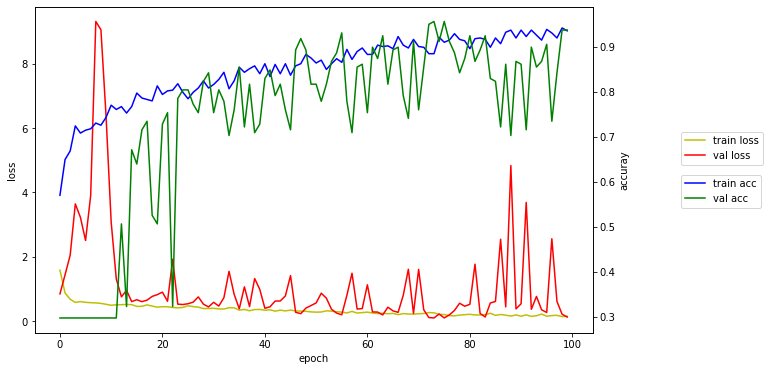

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()